<h1 style="font-size:30px;">Training the ASL Classifier using VGG-16</h1>  

In this notebook, we starting with a model pre-trained for imagenet, and adapt it for a different dataset: American Sign Language (ASL). We instantiate the feature extractor of the VGG-16 network architecture using pre-trained weights from the ImageNet dataset. Then we add our own classifier and re-trian the model on the ASL dataset.

**The standard training technique is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Add our custom classifier layer for the ASL dataset
3. Train the model (all layers)

<img src='./images/VGG16_04_asl_training.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Training the VGG-16 Model](#4-Training-the-VGG-16-Model)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)
* [7 Quantization](#7-Quantization)
* [8 Compilation](#8-Compilation)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

2023-04-19 08:10:20.488176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:10:20.624311: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 1 System Configuration

In [2]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
#download_file(
#    'https://www.dropbox.com/s/7huaqeavdbz32la/dataset_ASL_150.zip?dl=1', 
#    'dataset_ASL_150.zip'
#)
#    
#unzip(zip_file='dataset_ASL_150.zip')

## 3 Dataset and Training Configuration

In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 64
    #DATA_ROOT:   str = './dataset_ASL_150'
    DATA_ROOT:   str = './dataset_ASL_3000'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 64
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.001
    CHECKPOINT_DIR: str   = './saved_models_asl_2'

## 4 Training the VGG-16 Model

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Training.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

<img src='./images/VGG16_01_imagenet.png' width=1000 align='center'><br/>

In [4]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                include_top=True,
                                                weights='imagenet',
                                               )

Create an VGG16 model along with the imagenet pre-trained weights.


2023-04-19 08:10:31.393626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     


### 4.2 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

<img src='./images/VGG16_10_pretrained_base.png' width=1000 align='center'><br/>

In [6]:
print('Create an VGG16 model along with the imagenet pre-trained weights.')
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
vgg16_model_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                   )

Create an VGG16 model along with the imagenet pre-trained weights.


In [7]:
print(vgg16_model_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.4 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset.

<img src='./images/VGG16_03_asl_vitis_ai.png' width=1000 align='center'><br/>

In [8]:
print('Add Classification Layers (output or top)')
# Take the output of the VGG16 just before last layer
x = vgg16_model_base.layers[-1].output

# reduce the size of the last layer (7x7x512=25088)
# to account for conv2d/dense limitations in Vitis-AI
#x = tf.keras.layers.Conv2D(1024, (7, 7),name='block6_conv')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.MaxPooling2D()(x)
    
# Flatten the outputs of the last conv layer
flatten = tf.keras.layers.Flatten(name='flatten')(x)

# Fully Connected layers.
dense = tf.keras.layers.Dense(256, activation= 'relu',name='fc')(flatten)

# adding the prediction layer with 'softmax'
predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax',name='predictions')(dense)
    
# Create the new model with the new outputs
model = tf.keras.Model(inputs=vgg16_model_base.input, outputs=predictions)

Add Classification Layers (output or top)


In [9]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.5 Prepare the Training and Validation Dataset

In [9]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='training',
                                             validation_split=0.2
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             subset='validation',
                                             validation_split=0.2
                                            )

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


### 4.6 Display Sample Images

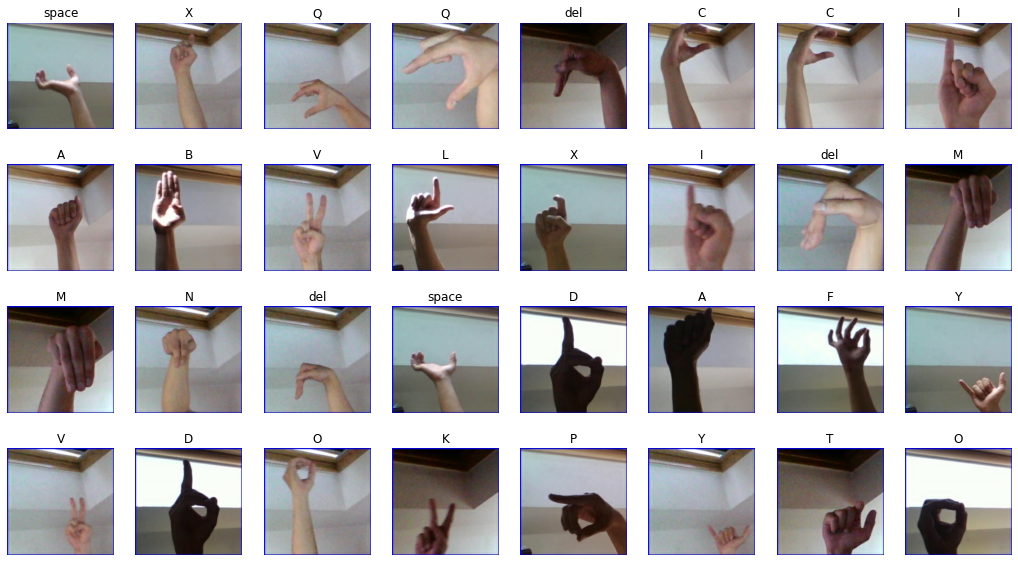

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.7 Compile and Train the Model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [12]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [13]:
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

272/272 [==============================] - 192s 701ms/step - loss: 1439.6959 - accuracy: 0.0386
Model evaluation accuracy: 3.862


In [14]:
from datetime import datetime

# datetime object containing current date and time
timestamp1 = datetime.now()
print(timestamp1)

2023-01-28 20:10:39.843257


In [15]:
# Train the Model.
training_results = model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
1088/1088 [==============================] - ETA: 0s - loss: 6.2471 - accuracy: 0.5003

2023-01-28 21:21:13.633331: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models_asl_2/assets
1088/1088 [==============================] - 4241s 4s/step - loss: 6.2471 - accuracy: 0.5003 - val_loss: 3.2644 - val_accuracy: 0.2661
Epoch 2/51
1088/1088 [==============================] - 4221s 4s/step - loss: 1.1656 - accuracy: 0.8769 - val_loss: 5.1361 - val_accuracy: 0.1691
Epoch 3/51
1088/1088 [==============================] - 4228s 4s/step - loss: 0.9437 - accuracy: 0.9078 - val_loss: 1.0437 - val_accuracy: 0.8655
Epoch 4/51
1088/1088 [==============================] - 4215s 4s/step - loss: 0.8611 - accuracy: 0.9190 - val_loss: 3.0005 - val_accuracy: 0.3814
Epoch 5/51
1088/1088 [==============================] - 4208s 4s/step - loss: 0.8148 - accuracy: 0.9229 - val_loss: 1.2519 - val_accuracy: 0.7863
Epoch 6/51
1088/1088 [==============================] - 4210s 4s/step - loss: 0.7508 - accuracy: 0.9275 - val_loss: 2.1229 - val_accuracy: 0.5968
Epoch 7/51
1088/1088 [==============================] - 4211s 4s/step - 

In [16]:
timestamp2 = datetime.now()
print(timestamp2)

print(timestamp2-timestamp1)

2023-01-31 08:07:03.295177
2 days, 11:56:23.451920


### 4.8 Plot the Training Results

In [17]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

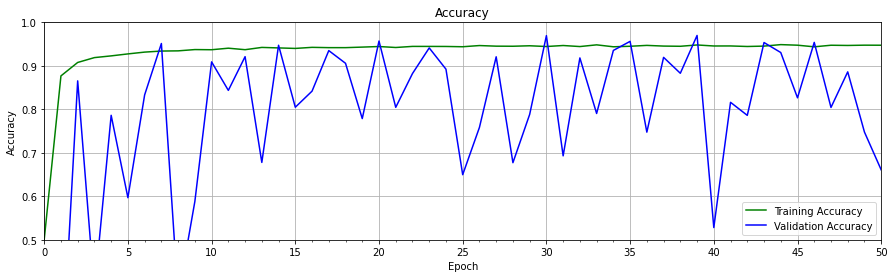

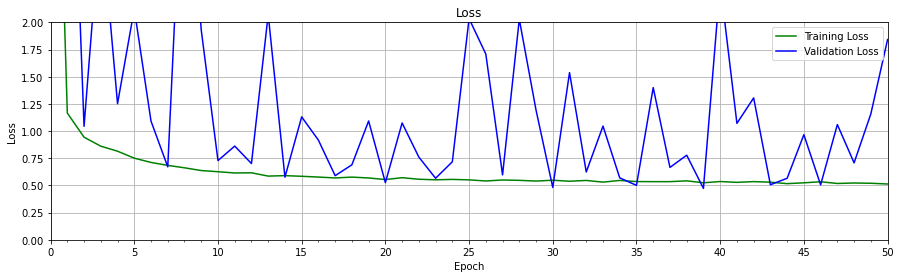

In [18]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation

In [19]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

272/272 [==============================] - 195s 713ms/step - loss: 0.4730 - accuracy: 0.9699
Model evaluation accuracy: 96.989


In [20]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

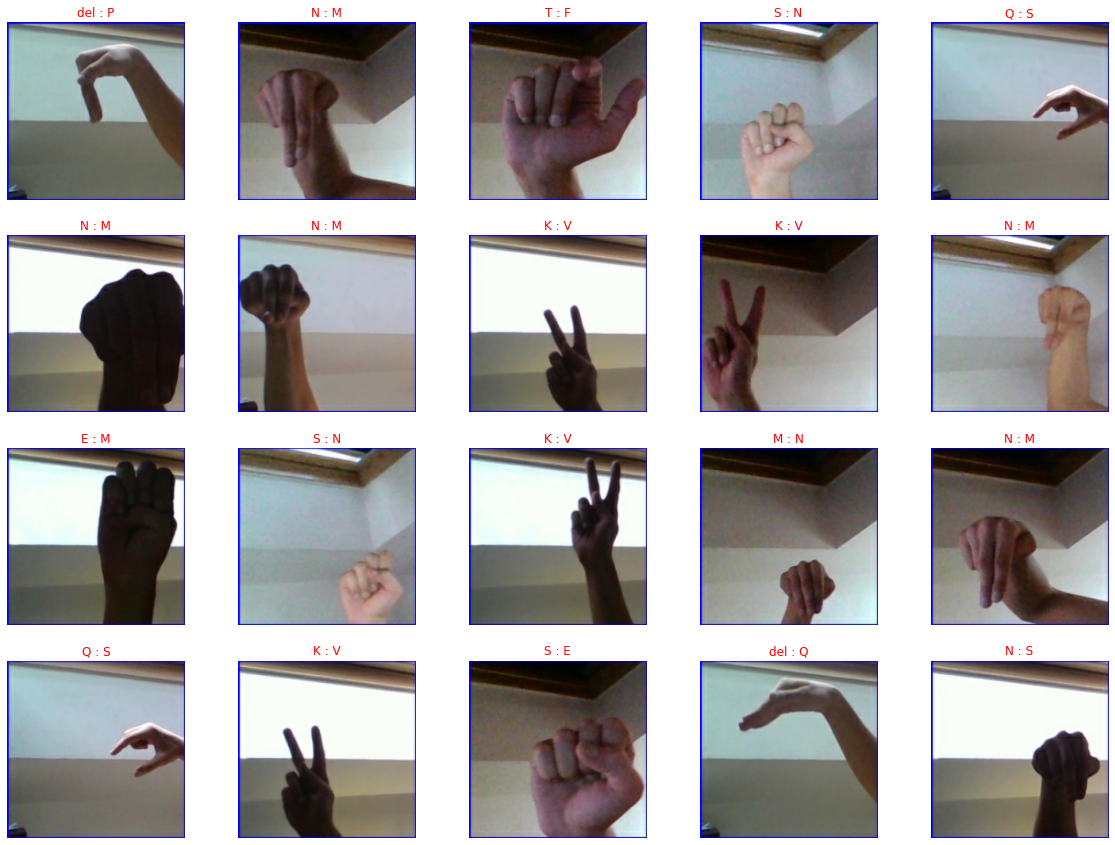

In [21]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 

**Save model**

Once we are happy with the performance of the model, we can save it as a .h5 file, simply using the `save` method.

In [22]:
print(model.summary())
model.save('tf2_asl_classifier1.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 112, 112, 16  64         ['conv2d_8[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 112, 112, 16  64         ['conv2d_7[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 112, 112, 16  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 activatio

                                                                                                  
 activation_15 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 dropout_15 (Dropout)           (None, 28, 28, 64)   0           ['activation_15[0][0]']          
                                                                                                  
 conv2d_16 (Conv2D)             (None, 28, 28, 64)   36928       ['dropout_15[0][0]']             
                                                                                                  
 batch_normalization_16 (BatchN  (None, 28, 28, 64)  256         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_24 (Conv2D)             (None, 7, 7, 128)    147584      ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_24 (BatchN  (None, 7, 7, 128)   512         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 dropout_24 (Dropout)           (None, 7, 7, 128)    0           ['activation_24[0][0]']          
                                                                                                  
 conv2d_25 (Conv2D)             (None, 7, 7, 17)     19601       ['dropout_24[0][0]']             
          

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [23]:

model = keras.models.load_model('tf2_asl_classifier1.h5')


## 7 Quantization

In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [24]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [25]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset=valid_dataset, weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 6s 665ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Standalone activation `softmax` layer activation_30 is not supported.
[VAI INFO] Start Quantize Calibration...
272/272 [==============================] - 780s 3s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [26]:
quantized_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
print(f"Model evaluation accuracy: {quantized_model.evaluate(valid_dataset)[1]*100.:.3f}")

272/272 [==============================] - 215s 777ms/step - loss: 5.6474 - accuracy: 0.9667
Model evaluation accuracy: 96.672


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [27]:
quantized_model.save('tf2_asl_classifier1_quantized.h5')

## 8 Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. 

The target platform (ie. specific DPU architecture) is defined by .arch file.

To support as many platforms as possible, we compile for the following DPU architectures:
- B4096 (ZCU102, ZCU104, UltraZed-EV)
- B3136 (KV260)
- B2304 (Ultra96-V2)
- B1152 (Ultra96-V2+DualCam)
-  B512 (ZUBoard)
-  B128 (ZUBoard+DualCam)

In [28]:
!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier1_quantized.h5 \
    --arch ./arch/B4096/arch-zcu104.json \
    --output_dir ./model1/B4096/ \
    --net_name asl_classifier1

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier1_quantized.h5 \
    --arch ./arch/B3136/arch-kv260.json \
    --output_dir ./model1/B3136/ \
    --net_name asl_classifier1

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier1_quantized.h5 \
    --arch ./arch/B2304/arch-b2304-lr.json \
    --output_dir ./model1/B2304/ \
    --net_name asl_classifier1

!vai_c_tensorflow2 \
    --model ./tf2_dobble_classifier1_quantized.h5 \
    --arch ./arch/B1152/arch-b1152-hr.json \
    --output_dir ./model1/B1152/ \
    --net_name asl_classifier1

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier1_quantized.h5 \
    --arch ./arch/B512/arch-b512-lr.json \
    --output_dir ./model1/B512/ \
    --net_name asl_classifier1

!vai_c_tensorflow2 \
    --model ./tf2_asl_classifier1_quantized.h5 \
    --arch ./arch/B128/arch-b128-lr.json \
    --output_dir ./model1/B128/ \
    --net_name asl_classifier1


**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_asl_classifier_2_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/asl_classifier_2_DPUCZDX8G_ISA1_B4096_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/tf2_asl_classifier_2_quantized.h5
[INFO] keras version: 2.8.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 108/108 [00:00<00:00, 4807.23it/s]          
[INFO] dump xmodel: /tmp/asl_classifier_2_DPUCZDX8G_ISA1_B4096_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: model, with op num: 232
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.


[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/./model_2/B128/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/./model_2/B128//asl_classifier_2.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is 0327e9818b6eafbbb88883b9838013cd, and has been saved to "/workspace/./model_2/B128/md5sum.txt"
